<a href="https://colab.research.google.com/github/Nakul450/Binary-Image-Classification-with-TensorFlow-Quantum-and-Cirq/blob/main/Binary_Image_Classification_on_Fashion_MNIST_with_TensorFlow_Quantum_and_Cirq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# STEP 1: Install Python 3.9 and set as default
!sudo apt-get update
!sudo apt-get install -y python3.9 python3.9-distutils
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 1
!sudo update-alternatives --config python3  # You may need to choose python3.9 manually here
!sudo apt-get install -y python3.9-venv

# STEP 2: Upgrade pip for Python 3.9
!python3 -m ensurepip --upgrade
!python3 -m pip install --upgrade pip setuptools wheel

# STEP 3: Install compatible packages
!python3 -m pip install tensorflow==2.14.0
!python3 -m pip install cirq==1.3.0
!python3 -m pip install protobuf==3.20.3
!python3 -m pip install sympy==1.12  # Required for TFQ 0.7.3
!python3 -m pip install tensorflow-quantum==0.7.3


In [58]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow_quantum as tfq
from cirq.contrib.svg import SVGCircuit
import matplotlib.pyplot as plt

In [59]:
from tensorflow.keras.datasets import fashion_mnist as dataset

In [60]:
(X_train,Y_train), (X_test,Y_test) = dataset.load_data()


In [61]:
def filter_data(x,y):
  keep = (y==5) | (y==9)
  x,y = x[keep], y[keep]
  y=(y==5)
  return x,y

In [62]:
X_train,Y_train=filter_data(X_train,Y_train)
X_test,Y_test=filter_data(X_test,Y_test)

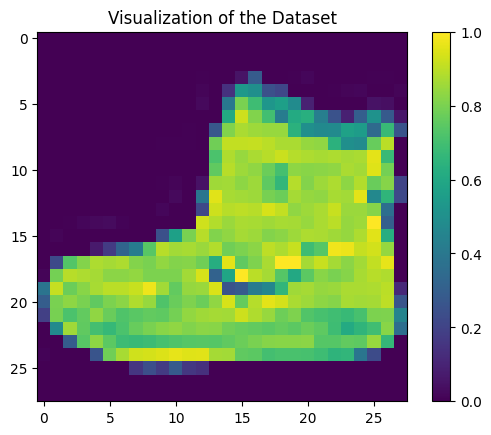

In [63]:
X_train = X_train / 255.0

# Visualize the first image
plt.imshow(X_train[0], cmap='viridis', interpolation='nearest')  # interpolation fixes zoom/blur
plt.colorbar()
plt.title("Visualization of the Dataset")
plt.show()

In [64]:
X_train = X_train.reshape(X_train.shape[0],*(28,28,1))
X_test = X_test.reshape(X_test.shape[0],*(28,28,1))

In [65]:
X_train = tf.image.resize(X_train,(2,2)).numpy()
X_test = tf.image.resize(X_test,(2,2)).numpy()

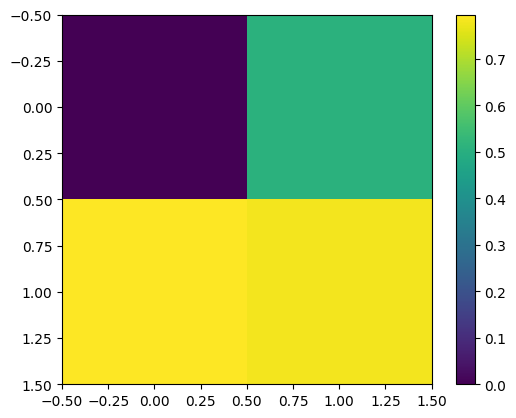

In [66]:
plt.imshow(X_train[0,:,:,0])
plt.colorbar()
plt.show()

In [67]:
X_train,X_valid,Y_train,Y_valid = train_test_split(X_train,Y_train,test_size=0.15,random_state=0)

In [68]:
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)

(10200, 2, 2, 1)
(10200,)
(1800, 2, 2, 1)
(1800,)


In [69]:
X_train=X_train.reshape(X_train.shape[0],*(1,4,1))
X_valid=X_valid.reshape(X_valid.shape[0],*(1,4,1))
X_test=X_test.reshape(X_test.shape[0],*(1,4,1))

In [70]:
def binary_encoder(X, threshold=0.5):
    encoded_images = list()
    for image in X:
        encoded_image = [1 if j>threshold else 0 for j in image[0]]
        encoded_images.append(encoded_image)
    return np.array(encoded_images)


In [71]:
X_train=binary_encoder(X_train)

In [72]:
import cirq
qubit=cirq.NamedQubit("bloom")
circuit = cirq.Circuit(cirq.X(qubit))

In [73]:
def create_circuit_from_image(encoded_image):
  qubits=cirq.GridQubit.rect(2,2)
  circuit=cirq.Circuit()
  for i,pixel in enumerate(encoded_image):
    if pixel:
      circuit.append(cirq.X(qubits[i]))
  return circuit

In [74]:
X_train=[create_circuit_from_image(encoded_image) for encoded_image in X_train]

In [75]:
print(X_train[0])

(1, 0): ───X───

(1, 1): ───X───


In [76]:
X_train_tfq = tfq.convert_to_tensor(X_train)

In [44]:
X_train_tfq[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'\n\x0e\n\x0ctfq_gate_set\x12\x02\x08\x01'>

In [77]:
X_valid= binary_encoder(X_valid)
X_test= binary_encoder(X_test)

In [78]:
X_valid = [create_circuit_from_image(encoded_image) for encoded_image in X_valid]
X_test = [create_circuit_from_image(encoded_image) for encoded_image in X_test]

In [79]:
X_valid_tfq = tfq.convert_to_tensor(X_valid)
X_test_tfq = tfq.convert_to_tensor(X_test)

In [86]:
import sympy

class QNN():
  def __init__(self,data_qubits,readout):
    self.data_qubits = data_qubits
    self.readout = readout

  def add_singleQubit_gate(self,circuit,gate,qubit_index):
    for index in qubit_index:
      circuit.append(gate(self.data_qubits[index]))

  def add_twoQubit_gate(self,circuit,gate,qubit_index):
    if len(qubit_index)!=2:
     raise Exception("The length of the list of indices passed for two qubit\gate operation must be equal to 2")
     circuit.append(gate(self.data_qubits[qubit_index[0]]. self.data_qubits[qubit_index[1]]))

  def add_layer(self,circuit,gate,symbol_gate):
    for i,qubit in enumerate(self.data_qubits):
      symbol = sympy.Symbol(symbol_gate+ '-' + str(i))
      circuit.append(gate(qubit,self.readout)**symbol)

In [87]:
def create_qnn():
  data_qubits = cirq.GridQubit.rect(2,2)
  readout = cirq.GridQubit(-1,-1)
  circuit = cirq.Circuit()

  circuit.append(cirq.X(readout))
  circuit.append(cirq.H(readout))

  qnn = QNN(
      data_qubits = data_qubits,
      readout=readout
  )

  qnn.add_layer(circuit, cirq.XX, "xx")
  qnn.add_layer(circuit, cirq.ZZ, "zz")

  circuit.append(cirq.H(readout))

  return circuit, cirq.Z(readout)

In [88]:
qmodel, model_readout = create_qnn()

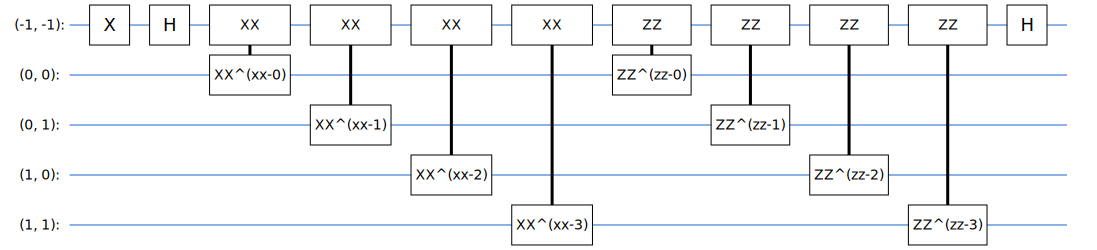

In [89]:
SVGCircuit(qmodel)

In [91]:
model = tf.keras.Sequential([

      tf.keras.layers.Input(shape=(), dtype=tf.string),
      tfq.layers.PQC(qmodel, model_readout),
])

In [92]:
Y_train_h = np.array([1 if i==1 else -1 for i in Y_train ])
Y_valid_h = np.array([1 if i==1 else -1 for i in Y_valid ])
Y_test_h = np.array([1 if i==1 else -1 for i in Y_test ])

In [94]:
print(Y_train_h[1])

-1


In [95]:
def hinge_accuracy(Y_true,Y_pred):
  Y_true = tf.squeeze(Y_true) > 0.0
  Y_pred = tf.squeeze(Y_pred) > 0.0
  result = tf.cast(Y_true == Y_pred, tf.float32)

  return tf.reduce_mean(result)

In [96]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[hinge_accuracy]
)

In [97]:
qnn_history = model.fit(
    X_train_tfq,Y_train_h,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=(X_valid_tfq,Y_valid_h)

)

Epoch 1/10
160/160 [==============================] - 19s 86ms/step - loss: 0.7698 - hinge_accuracy: 0.7235 - val_loss: 0.5667 - val_hinge_accuracy: 0.7915
Epoch 2/10
160/160 [==============================] - 11s 67ms/step - loss: 0.5339 - hinge_accuracy: 0.7599 - val_loss: 0.4367 - val_hinge_accuracy: 0.7915
Epoch 3/10
160/160 [==============================] - 12s 74ms/step - loss: 0.4842 - hinge_accuracy: 0.7602 - val_loss: 0.4228 - val_hinge_accuracy: 0.7915
Epoch 4/10
160/160 [==============================] - 12s 76ms/step - loss: 0.4803 - hinge_accuracy: 0.7602 - val_loss: 0.4222 - val_hinge_accuracy: 0.7915
Epoch 5/10
160/160 [==============================] - 13s 80ms/step - loss: 0.4802 - hinge_accuracy: 0.7600 - val_loss: 0.4222 - val_hinge_accuracy: 0.7915
Epoch 6/10
160/160 [==============================] - 13s 80ms/step - loss: 0.4802 - hinge_accuracy: 0.7599 - val_loss: 0.4222 - val_hinge_accuracy: 0.7915
Epoch 7/10
160/160 [==============================] - 13s 81ms/s

In [99]:
model.evaluate(X_test_tfq,Y_test_h)

63/63 [==============================] - 2s 24ms/step - loss: 0.5650 - hinge_accuracy: 0.7168


[0.5649999976158142, 0.7167658805847168]

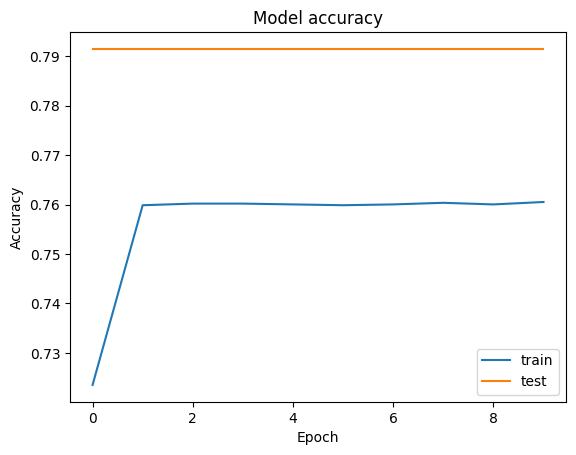

In [100]:
plt.plot(qnn_history.history['hinge_accuracy'])
plt.plot(qnn_history.history['val_hinge_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','test'],loc="best")
plt.show()

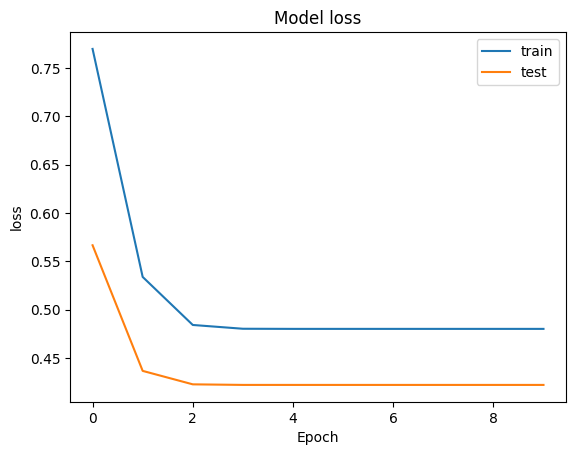

In [101]:
plt.plot(qnn_history.history['loss'])
plt.plot(qnn_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(['train','test'],loc="best")
plt.show()

In [102]:
model.save_weights('/content/sample_data/QModelWeights')